# Urban and rural surrounding areas selection

***
> This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0)
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

This notebook presents a comprehensive analysis of how the functions UHI_analysis and urban_area operate across multiple spatial resolutions — specifically 25 km, 12 km, and 3 km — using the city of Paris as a case study. The objective is to evaluate the sensitivity of the Urban Heat Island (UHI) signal and urban classification methods to changes in model resolution. This comparison aims to highlight potential discrepancies in urban climate metrics and assess the robustness of the methods when applied to datasets of varying granularity.

## Load libraries

Here we load the required libraries to execute the notebook. Note that specific code from dedicated scripts (`utils.py`, `urban_areas.py`, ...) is also loaded here.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import numpy as np
import xarray as xr
import cf_xarray as cfxr
from pathlib import Path
import cftime
import pandas as pd
import matplotlib
from pprint import pprint

from urclimask.urban_areas import (
    UrbanVicinity
)
from urclimask.UHI_plot_functions import (
    plot_climatology,
    plot_annual_cycle
)
from urclimask.utils import (
    kelvin2degC,
    traverseDir,
    fix_360_longitudes,
    RCM_DICT,
    load_ucdb_city
)
from urclimask.UHI_analysis import UrbanIsland

from urclimask.GHCNd_stations import (
    load_ghcnd_stations,
    get_ghcnd_df,
    get_valid_timeseries,
    available_vars,
    inside_city
)

# CORDEX-CORE (0.22° resolution) – REMO Model

This dataset corresponds to the CORDEX-CORE initiative at 0.22° (~25 km) resolution, using the REMO regional climate model. It provides high-resolution simulations suitable for analyzing urban climate and UHI effects across Europe and other domains.


In [3]:
city = 'Paris'
lon_city = 2.35
lat_city = 48.85

domain = 'EUR-22'
model = 'REMO'
scenario = "evaluation"

urban_var = 'sftimf'

urban_th = 10
urban_sur_th = 10
orog_diff = 100
sftlf_th = 70
scale = 2
min_city_size = 10
lon_lim = 1
lat_lim = 1

Create a directory to save the results for this particular city and model

In [51]:
base_output_dir = 'results'
output_dir = f"{base_output_dir}/{city}-{domain}_{model}"
os.makedirs(output_dir, exist_ok = True)

Infer doman resolution in degrees and create filename

In [52]:
domain_resolution = int(domain.split('-')[1])
base_filename = f'{city}-{domain}_ECMWF-ERA5_{scenario}_r1i1p1f1_{model}'

## Define urban areas and vicinity

### Load static variables
Load static variables, such as urban fraction (sfturf), terrain elevation (orography) or land-sea fraction (sftlf).

In [4]:
root_nextcloud = '.../CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'
root_esgf = ".../cordex/output/"

In [54]:
file_sfturf = glob.glob(
        f"{root_nextcloud}{model}/{urban_var}/{urban_var}_{domain}*.nc" 
)

file_orog = glob.glob(
    f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/ECMWF-ERAINT/evaluation/*/{RCM_DICT[domain][model].split('_')[1]}/*/fx/orog/*/orog_*.nc" 
)
file_sftlf = glob.glob(
    f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/ECMWF-ERAINT/evaluation/*/{RCM_DICT[domain][model].split('_')[1]}/*/fx/sftlf/*/sftlf_*.nc" 
)

In [55]:
ds_sfturf = xr.open_dataset(file_sfturf[0])
ds_orog = xr.open_dataset(file_orog[0])
ds_sftlf = xr.open_dataset(file_sftlf[0])

ds_sfturf = fix_360_longitudes(ds_sfturf)
ds_orog = fix_360_longitudes(ds_orog)
ds_sftlf = fix_360_longitudes(ds_sftlf)

Add parameters to the function

In [56]:
URBAN = UrbanVicinity(
    urban_sur_th = urban_sur_th,
    orog_diff = orog_diff,
    sftlf_th = sftlf_th,
    scale = scale,
    min_city_size = min_city_size,
    lon_city = lon_city,
    lat_city = lat_city,
    lon_lim = lon_lim,
    lat_lim = lat_lim,
    model = model,
    domain = domain,
    urban_th = urban_th,
    urban_var = urban_var
)

Crop area around de city

In [57]:
ds_sfturf = URBAN.crop_area_city(ds = ds_sfturf, res = domain_resolution)
ds_orog = URBAN.crop_area_city(ds = ds_orog, res = domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds = ds_sftlf, res = domain_resolution)

Define masks using the parameters above

In [ ]:
sfturf_mask, sfturf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sfturf = ds_sfturf, 
    ds_orog = ds_orog, 
    ds_sftlf = ds_sftlf,
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [59]:
urmask = URBAN.select_urban_vicinity(
    sfturf_mask = sfturf_mask, 
    orog_mask = orog_mask,
    sftlf_mask = sftlf_mask,
    sfturf_sur_mask = sfturf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

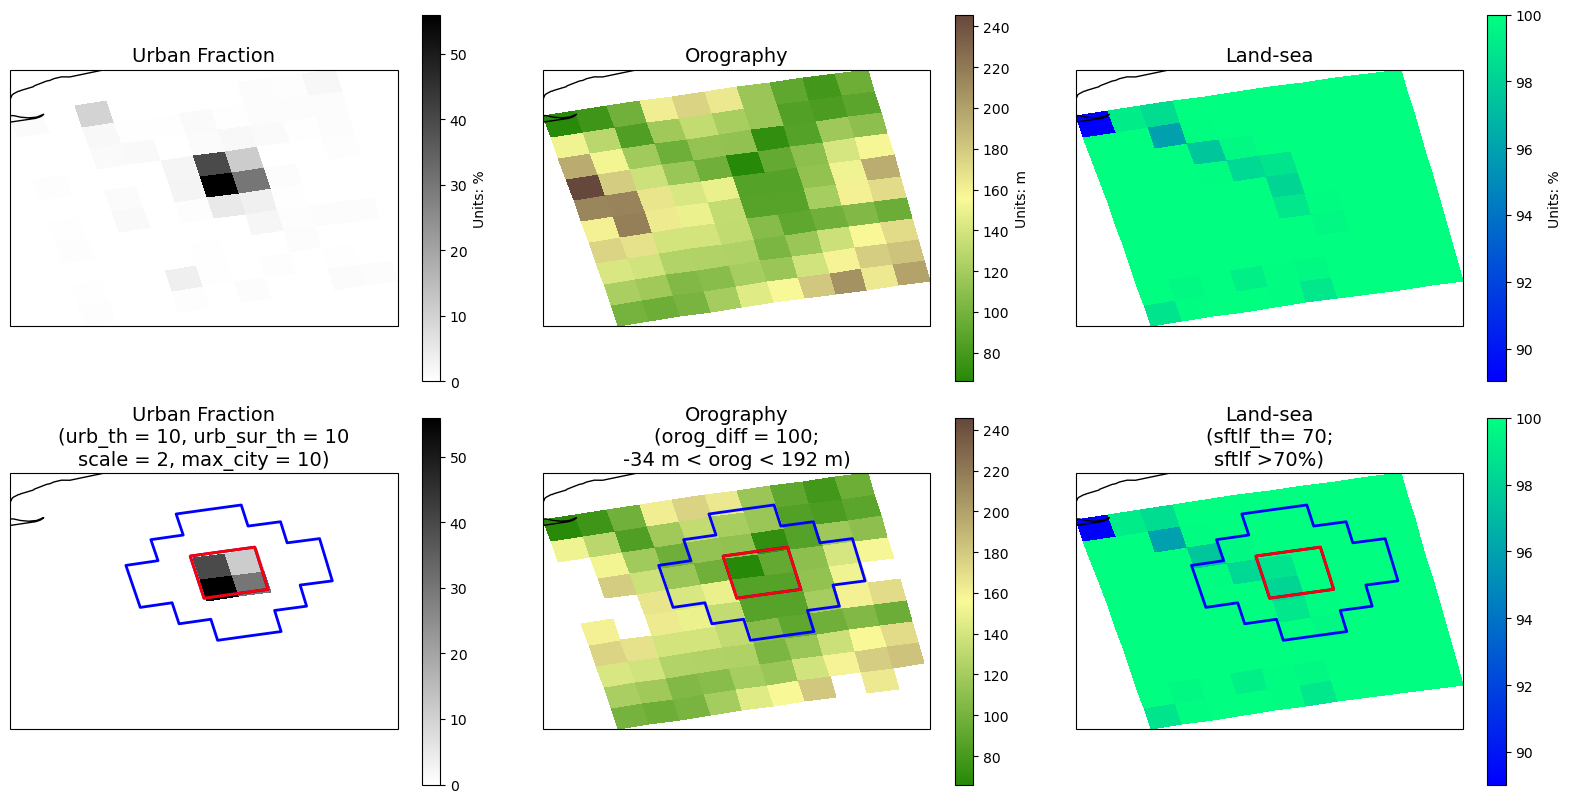

In [60]:
fig = URBAN.plot_static_variables(ds_sfturf = ds_sfturf, 
                                  ds_orog = ds_orog, 
                                  ds_sftlf = ds_sftlf,
                                  sfturf_mask = sfturf_mask, 
                                  orog_mask = orog_mask, 
                                  sftlf_mask = sftlf_mask,
                                  urban_areas = urmask)
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')

Save these masks and urban fraction to NetCDF

In [61]:
urmask.to_netcdf(f"{output_dir}/urmask_{base_filename}_fx.nc")

## Calculate Urban Heat Island (UHI)

### Load climate variable

In [62]:
variable = 'tasmin'

In [63]:
files_pattern = f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/*/{scenario}/*/{RCM_DICT[domain][model].split('_')[1]}/*/day/{variable}/*/{variable}_*.nc"
files = glob.glob(files_pattern)
ds_RCM = xr.open_mfdataset(sorted(files), combine='nested', concat_dim='time')

In [64]:
ds_RCM = kelvin2degC(ds_RCM, variable)
ds_RCM = fix_360_longitudes(ds_RCM)
ds_RCM = URBAN.crop_area_city(ds = ds_RCM, res = domain_resolution)

### Load city shapefile

In [65]:
root_nextcloud = '/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'
ucdb_city = load_ucdb_city(root_nextcloud, city)

## Observations

### Load the observations data

In [66]:
output_file = "PARIS_surface_weather_data/Data_MF_1980-2017.csv"
radious = 0.5

stan_data = pd.read_csv(output_file)
stan_data['code'] = stan_data['code'].astype(str)

In [67]:
stan_data = stan_data.loc[stan_data['dist'] < radious]

### Select coincident period between Model and Observations

In [ ]:
valid_obs, time_series_obs, ds_RCM_period = get_valid_timeseries(
    city, stan_data, ds_RCM, variable, idate='1979-01-01', fdate='2014-12-31', divide= 1
)

#### Calculate observations both inside and outside the city

In [ ]:
valid_obs = inside_city(valid_obs, ucdb_city)

### Compute the annual cycle climatology of anomalies with respect to rural vicinity mean

In [70]:
UHI = UrbanIsland(
    ds = ds_RCM_period[variable],
    urban_vicinity = urmask,
    anomaly = 'abs',
    obs_attributes = valid_obs,
    obs_timeseries = time_series_obs
)

## Plot the data

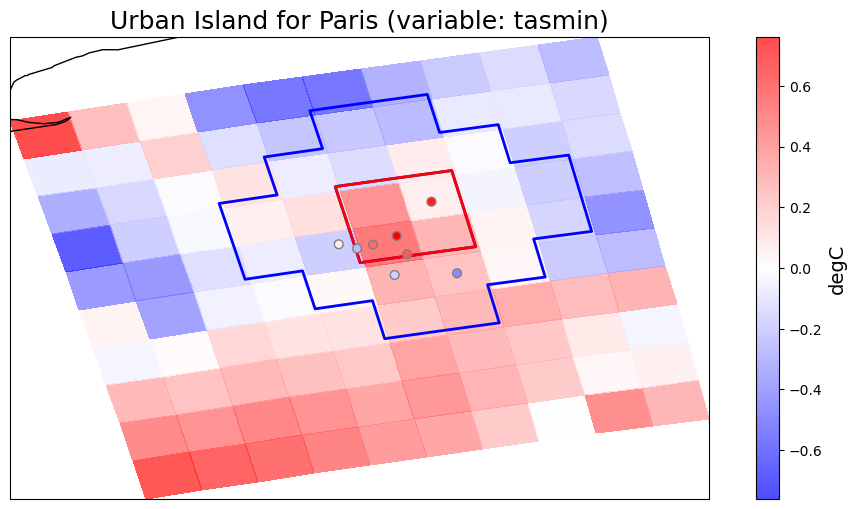

In [71]:
fig = UHI.plot_UI_map(
    city_name = city,
)
fig.savefig(f"{output_dir}/{variable}_{base_filename}_map-anom-wrt-rural.pdf", bbox_inches='tight')

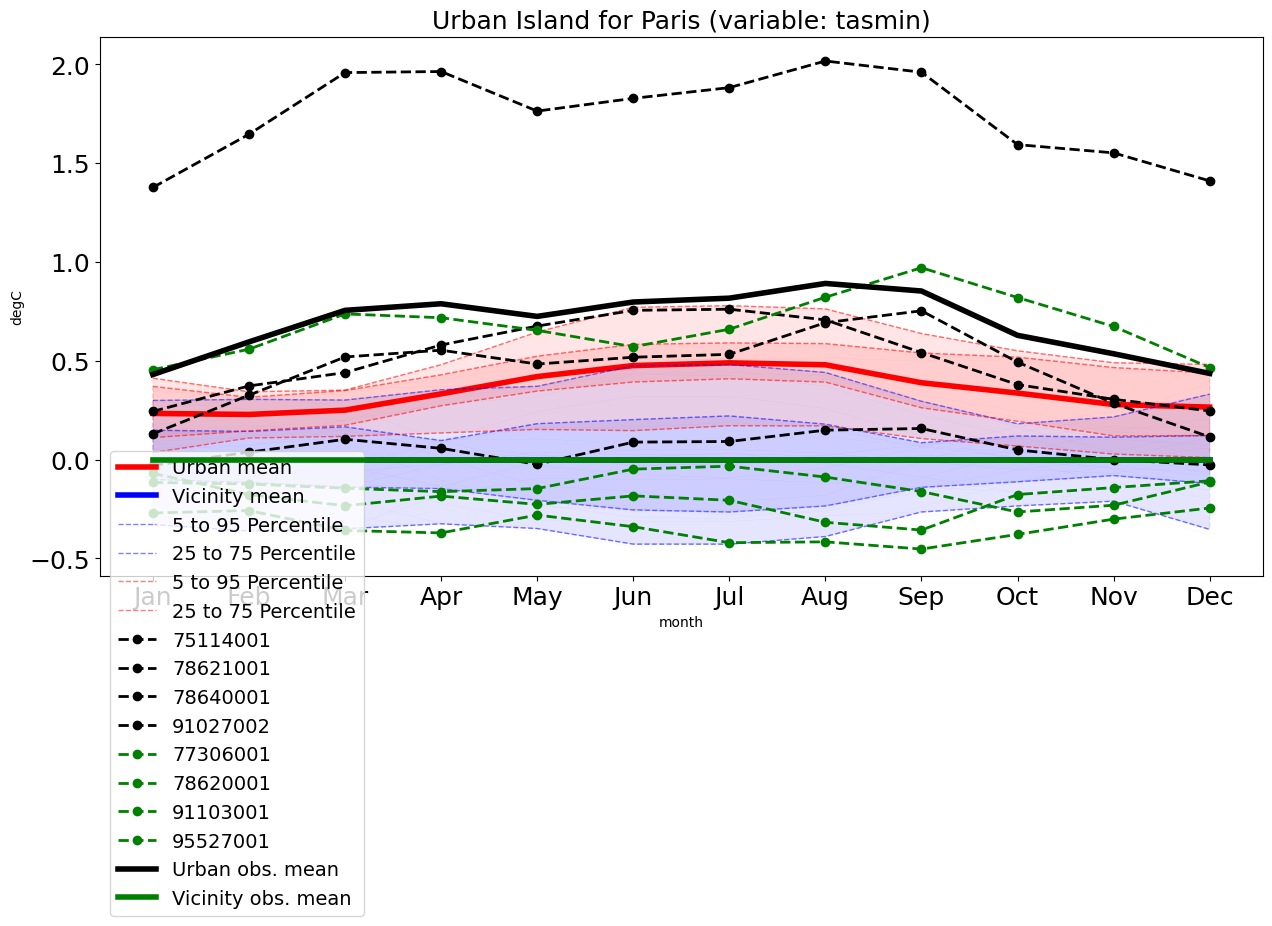

In [72]:
fig = UHI.plot_UI_annual_cycle(
    percentiles = [5,25],
    gridcell_series = True, 
    city_name = city)

## Input parameters

These parameters define the behaviour of the notebook, by selecting the `city`, `variable`, and some other items which are mostly -explanatory. _(Explain here those with are not)_

# CORDEX-EUR-11 (0.11° resolution) – REMO Model
This dataset belongs to the EURO-CORDEX project at 0.11° (~12 km) resolution, using the REMO regional climate model. The finer spatial resolution allows for a more detailed representation of urban structures and local climate phenomena, enabling a refined assessment of the UHI effect in urban environments within the EUR-11 domain.

## Input parameters

These parameters define the behaviour of the notebook, by selecting the `city`, `variable`, and some other items which are mostly -explanatory. _(Explain here those with are not)_

In [73]:
city = 'Paris'
lon_city = 2.35
lat_city = 48.85

domain = 'EUR-11'
model = 'REMO'
scenario = "evaluation"

urban_var = 'sftimf'

urban_th = 40
urban_sur_th = 10
orog_diff = 100
sftlf_th = 70
scale = 2
min_city_size = 5
lon_lim = 1
lat_lim = 1

Create a directory to save the results for this particular city and model

In [74]:
base_output_dir = 'results'
output_dir = f"{base_output_dir}/{city}-{domain}_{model}"
os.makedirs(output_dir, exist_ok = True)

Infer doman resolution in degrees and create filename

In [75]:
domain_resolution = int(domain.split('-')[1])
base_filename = f'{city}-{domain}_ECMWF-ERA5_{scenario}_r1i1p1f1_{model}'

## Define urban areas and vicinity

### Load static variables
Load static variables, such as urban fraction (sfturf), terrain elevation (orography) or land-sea fraction (sftlf).

In [76]:
root_nextcloud = '.../CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'
root_esgf = ".../cordex/output/"

In [77]:
file_sfturf = glob.glob(
        f"{root_nextcloud}{model}/{urban_var}/{urban_var}_{domain}*.nc" 
)

file_orog = glob.glob(
    f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/ECMWF-ERAINT/evaluation/*/{RCM_DICT[domain][model].split('_')[1]}/*/fx/orog/*/orog_*.nc" 
)
file_sftlf = glob.glob(
    f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/ECMWF-ERAINT/evaluation/*/{RCM_DICT[domain][model].split('_')[1]}/*/fx/sftlf/*/sftlf_*.nc" 
)

In [78]:
ds_sfturf = xr.open_dataset(file_sfturf[0])
ds_orog = xr.open_dataset(file_orog[0])
ds_sftlf = xr.open_dataset(file_sftlf[0])

ds_sfturf = fix_360_longitudes(ds_sfturf)
ds_orog = fix_360_longitudes(ds_orog)
ds_sftlf = fix_360_longitudes(ds_sftlf)

Add parameters to the function

In [79]:
URBAN = UrbanVicinity(
    urban_sur_th = urban_sur_th,
    orog_diff = orog_diff,
    sftlf_th = sftlf_th,
    scale = scale,
    min_city_size = min_city_size,
    lon_city = lon_city,
    lat_city = lat_city,
    lon_lim = lon_lim,
    lat_lim = lat_lim,
    model = model,
    domain = domain,
    urban_th = urban_th,
    urban_var = urban_var
)

Crop area around de city

In [80]:
ds_sfturf = URBAN.crop_area_city(ds = ds_sfturf, res = domain_resolution)
ds_orog = URBAN.crop_area_city(ds = ds_orog, res = domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds = ds_sftlf, res = domain_resolution)

Define masks using the parameters above

In [ ]:
sfturf_mask, sfturf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sfturf = ds_sfturf, 
    ds_orog = ds_orog, 
    ds_sftlf = ds_sftlf,
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [82]:
urmask = URBAN.select_urban_vicinity(
    sfturf_mask = sfturf_mask, 
    orog_mask = orog_mask,
    sftlf_mask = sftlf_mask,
    sfturf_sur_mask = sfturf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

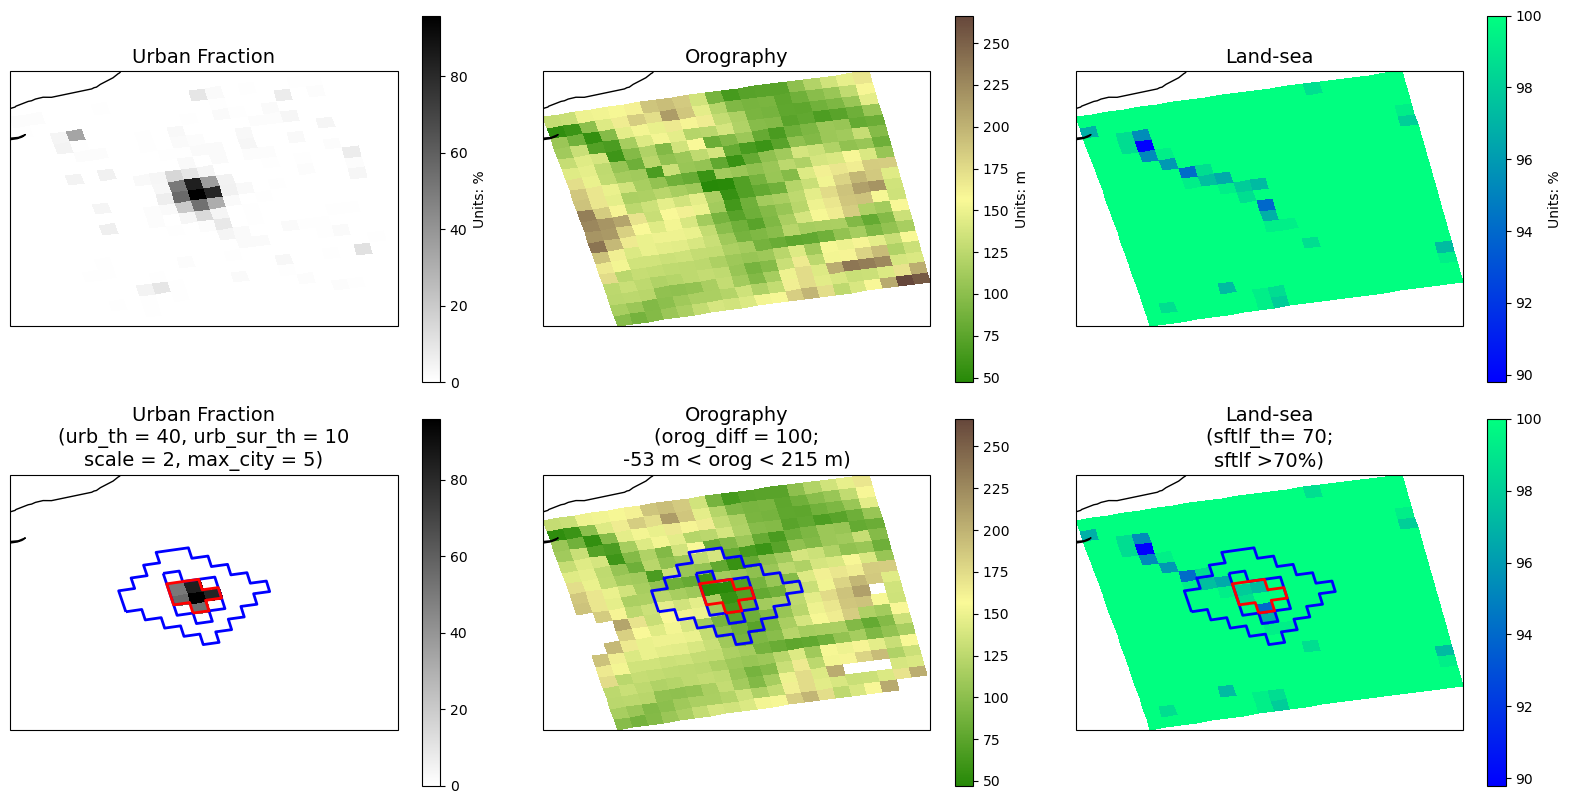

In [83]:
fig = URBAN.plot_static_variables(ds_sfturf = ds_sfturf, 
                                  ds_orog = ds_orog, 
                                  ds_sftlf = ds_sftlf,
                                  sfturf_mask = sfturf_mask, 
                                  orog_mask = orog_mask, 
                                  sftlf_mask = sftlf_mask,
                                  urban_areas = urmask)
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')

Save these masks and urban fraction to NetCDF

In [84]:
urmask.to_netcdf(f"{output_dir}/urmask_{base_filename}_fx.nc")

## Calculate Urban Heat Island (UHI)

### Load climate variable

In [85]:
variable = 'tasmin'

In [86]:
files_pattern = f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/*/{scenario}/*/{RCM_DICT[domain][model].split('_')[1]}/*/day/{variable}/*/{variable}_*.nc"
files = glob.glob(files_pattern)
ds_RCM = xr.open_mfdataset(sorted(files), combine='nested', concat_dim='time')

In [87]:
ds_RCM = kelvin2degC(ds_RCM, variable)
ds_RCM = fix_360_longitudes(ds_RCM)
ds_RCM = URBAN.crop_area_city(ds = ds_RCM, res = domain_resolution)

### Compute the climatology of anomalies with respect to rural vicinity mean

In [88]:
UHI = UrbanIsland(
    ds = ds_RCM[variable],
    urban_vicinity = urmask,
    anomaly = 'abs'
)

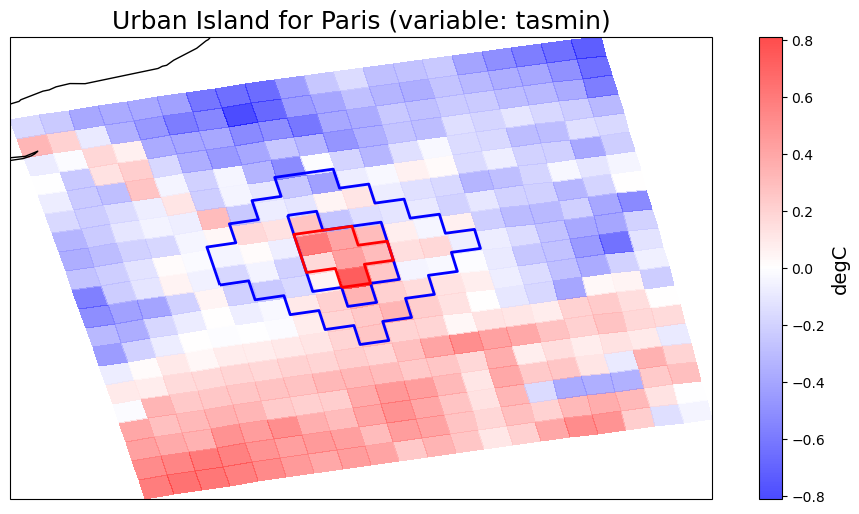

In [89]:
fig = UHI.plot_UI_map(
    city_name = city,
)
fig.savefig(f"{output_dir}/{variable}_{base_filename}_map-anom-wrt-rural.pdf", bbox_inches='tight')

### Compute the annual cycle climatology of anomalies with respect to rural vicinity mean

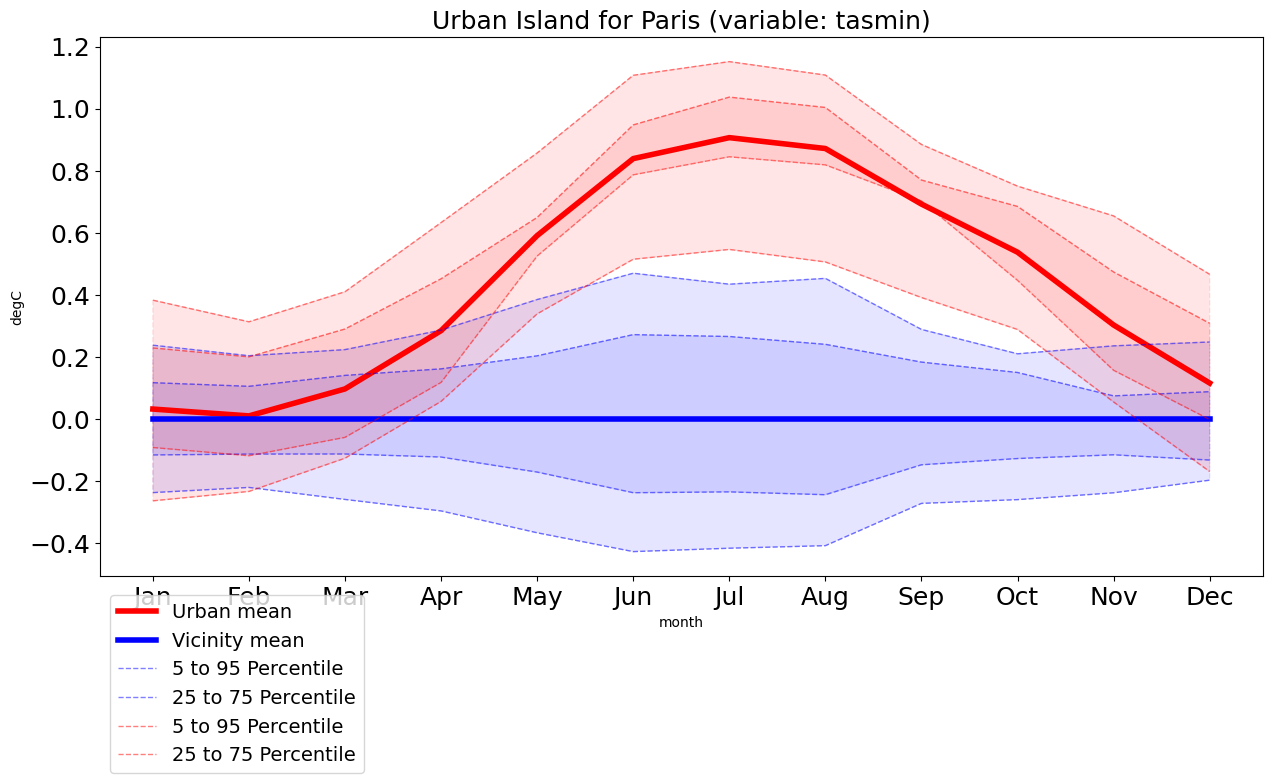

In [90]:
fig = UHI.plot_UI_annual_cycle(
    percentiles = [5,25],
    gridcell_series = False, 
    city_name = city)

# CORDEX-EUR-03 (0.03° resolution) – REMO Model
This dataset is part of a high-resolution EURO-CORDEX experiment at 0.03° (~3 km) resolution, using the REMO model. At convection-permitting scales, the simulation captures finer urban details and mesoscale processes, offering an advanced perspective on the spatial extent and intensity of the UHI effect in complex urban landscapes like Paris.

## Input parameters

These parameters define the behaviour of the notebook, by selecting the `city`, `variable`, and some other items which are mostly -explanatory. _(Explain here those with are not)_

In [92]:
abbr_city = 'Paris'

variable = 'tas'
urban_var = 'sftimf'
observations = True
domain = 'EUR-03'
model = 'REMO' # REMO/RegCM
scenario = 'evaluation'
root_esgf = '.../cordex/output/'
root_nextcloud = '.../CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'
base_output_dir = 'results_paper'

lon_city = 2.35
lat_city = 48.85

urban_th = 90
urban_sur_th = 40
orog_diff = 100
sftlf_th = 70
scale = 1
min_city_size = 5# remove small urban centers (numbero of cells)
lon_lim = 1
lat_lim = 1

Create a directory to save the results for this particular city and model

In [93]:
base_output_dir = 'results'
output_dir = f"{base_output_dir}/{abbr_city}-{domain}_{model}"
os.makedirs(output_dir, exist_ok = True)

Infer doman resolution in degrees and create filename

In [94]:
domain_resolution = 3
base_filename = f'{abbr_city}-{domain}_ECMWF-ERA5_{scenario}_r1i1p1f1_{model}'

## Define urban areas and vicinity

### Load static variables
Load static variables, such as urban fraction (sfturf), terrain elevation (orography) or land-sea fraction (sftlf).

In [95]:
root = '.../PARIS-3/GERICS/ERA5/evaluation/r1i1p1f1/REMO2020-TEB/v1-fpsurbrcc-s0r1/'

In [96]:
ds_sftuf = xr.open_dataset(root + "fx/sfturf/v20241211/sfturf_PARIS-3_ERA5_evaluation_r1i1p1f1_GERICS_REMO2020-TEB_v1-fpsurbrcc-s0r1_fx.nc")
ds_orog = xr.open_dataset(root + "fx/orog/v20241211/orog_PARIS-3_ERA5_evaluation_r1i1p1f1_GERICS_REMO2020-TEB_v1-fpsurbrcc-s0r1_fx.nc")
ds_sftlf = xr.open_dataset(root + "fx/sftlf/v20241211/sftlf_PARIS-3_ERA5_evaluation_r1i1p1f1_GERICS_REMO2020-TEB_v1-fpsurbrcc-s0r1_fx.nc")

In [97]:
ds_sftuf['sftimf']=ds_sftuf['sfturf']

Add parameters to the function

In [98]:
URBAN = UrbanVicinity(
    urban_sur_th = urban_sur_th,
    orog_diff = orog_diff,
    sftlf_th = sftlf_th,
    scale = scale,
    min_city_size = min_city_size,
    lon_city = lon_city,
    lat_city = lat_city,
    lon_lim = lon_lim,
    lat_lim = lat_lim,
    model = model,
    domain = domain,
    urban_th = urban_th,
    urban_var = urban_var
)

Crop area around de city

In [99]:
ds_sfturf = URBAN.crop_area_city(ds = ds_sftuf, res = domain_resolution)
ds_orog = URBAN.crop_area_city(ds = ds_orog, res = domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds = ds_sftlf, res = domain_resolution)

Define masks using the parameters above

In [100]:
sfturf_mask, sfturf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sfturf = ds_sfturf, 
    ds_orog = ds_orog, 
    ds_sftlf = ds_sftlf,
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [101]:
urmask = URBAN.select_urban_vicinity(
    sfturf_mask = sfturf_mask, 
    orog_mask = orog_mask,
    sftlf_mask = sftlf_mask,
    sfturf_sur_mask = sfturf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

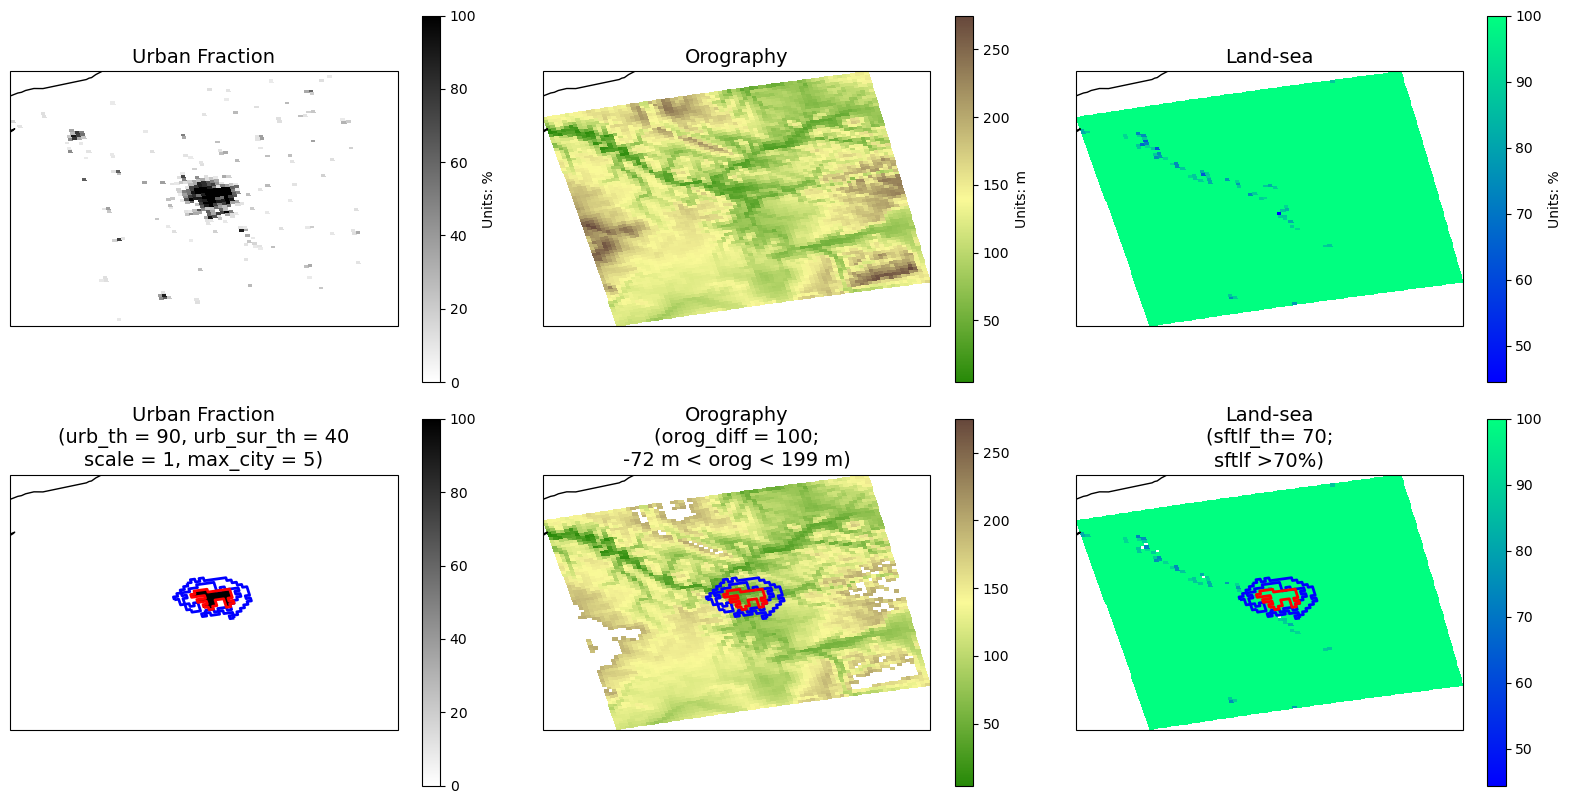

In [102]:
fig = URBAN.plot_static_variables(ds_sfturf = ds_sfturf, 
                                  ds_orog = ds_orog, 
                                  ds_sftlf = ds_sftlf,
                                  sfturf_mask = sfturf_mask, 
                                  orog_mask = orog_mask, 
                                  sftlf_mask = sftlf_mask,
                                  urban_areas = urmask)
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')

Save these masks and urban fraction to NetCDF

In [103]:
urmask.to_netcdf(f"{output_dir}/urmask_{base_filename}_fx.nc")

## Calculate Urban Heat Island (UHI)

### Load climate variable

In [104]:
variable = 'tas'

In [105]:
files_pattern = f"{root}1hr/{variable}/*/*{variable}_*.nc"
files = glob.glob(files_pattern)
ds_RCM = xr.open_mfdataset(sorted(files), combine='nested', concat_dim='time')

In [106]:
ds_RCM = kelvin2degC(ds_RCM, variable)
ds_RCM = fix_360_longitudes(ds_RCM)
ds_RCM = URBAN.crop_area_city(ds = ds_RCM, res = domain_resolution)

### Compute the climatology of anomalies with respect to rural vicinity mean

In [107]:
UHI = UrbanIsland(
    ds = ds_RCM[variable],
    urban_vicinity = urmask,
    anomaly = 'abs'
)

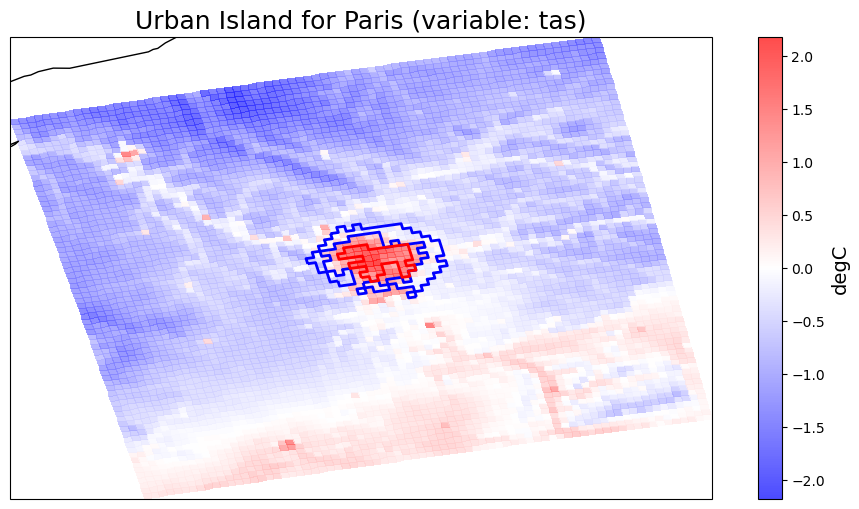

In [108]:
fig = UHI.plot_UI_map(
    city_name = abbr_city,
)
fig.savefig(f"{output_dir}/{variable}_{base_filename}_map-anom-wrt-rural.pdf", bbox_inches='tight')

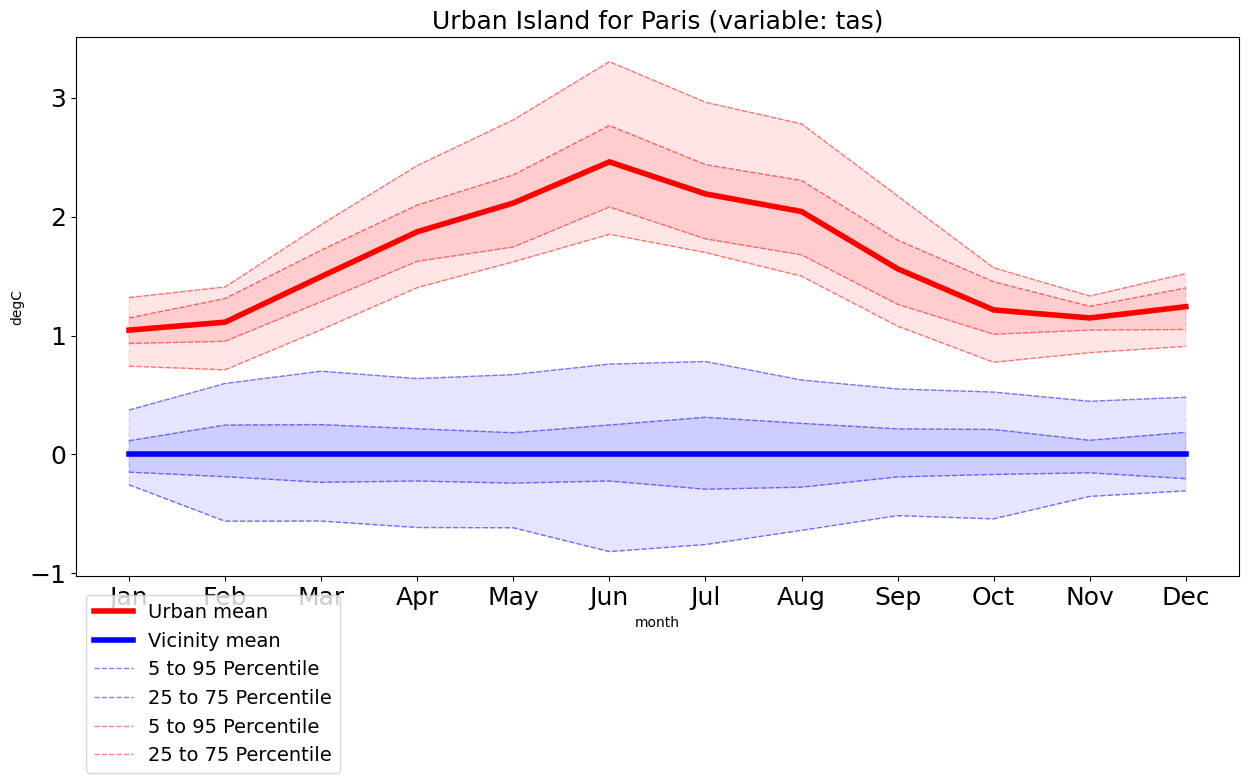

In [109]:
fig = UHI.plot_UI_annual_cycle(
    percentiles = [5,25],
    gridcell_series = False, 
    city_name = abbr_city)

### Compute the annual cycle climatology of anomalies with respect to rural vicinity mean

## Example on how the parameter "urban_sur_th" works
The parameter “urban_sur_th” creates a buffer zone around urban cells. Cells with UF values between “urban_th” and “urban_sur_th”, which might be affected by the urban climate and should not be considered rural surrounding areas, are excluded from the analysis. This parameter is particularly relevant for high-resolution climate models and only affects the results if the hyperparameter “urban_th” and “urban_sur_th”  are different.
Let's recreate the same mask but with a different urban_sur_th value to see the diferences.

In [110]:
urban_sur_th = 90

In [111]:
URBAN = UrbanVicinity(
    urban_sur_th = urban_sur_th,
    orog_diff = orog_diff,
    sftlf_th = sftlf_th,
    scale = scale,
    min_city_size = min_city_size,
    lon_city = lon_city,
    lat_city = lat_city,
    lon_lim = lon_lim,
    lat_lim = lat_lim,
    model = model,
    domain = domain,
    urban_th = urban_th,
    urban_var = urban_var
)

In [112]:
sfturf_mask, sfturf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sfturf = ds_sfturf, 
    ds_orog = ds_orog, 
    ds_sftlf = ds_sftlf,
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [113]:
urmask = URBAN.select_urban_vicinity(
    sfturf_mask = sfturf_mask, 
    orog_mask = orog_mask,
    sftlf_mask = sftlf_mask,
    sfturf_sur_mask = sfturf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

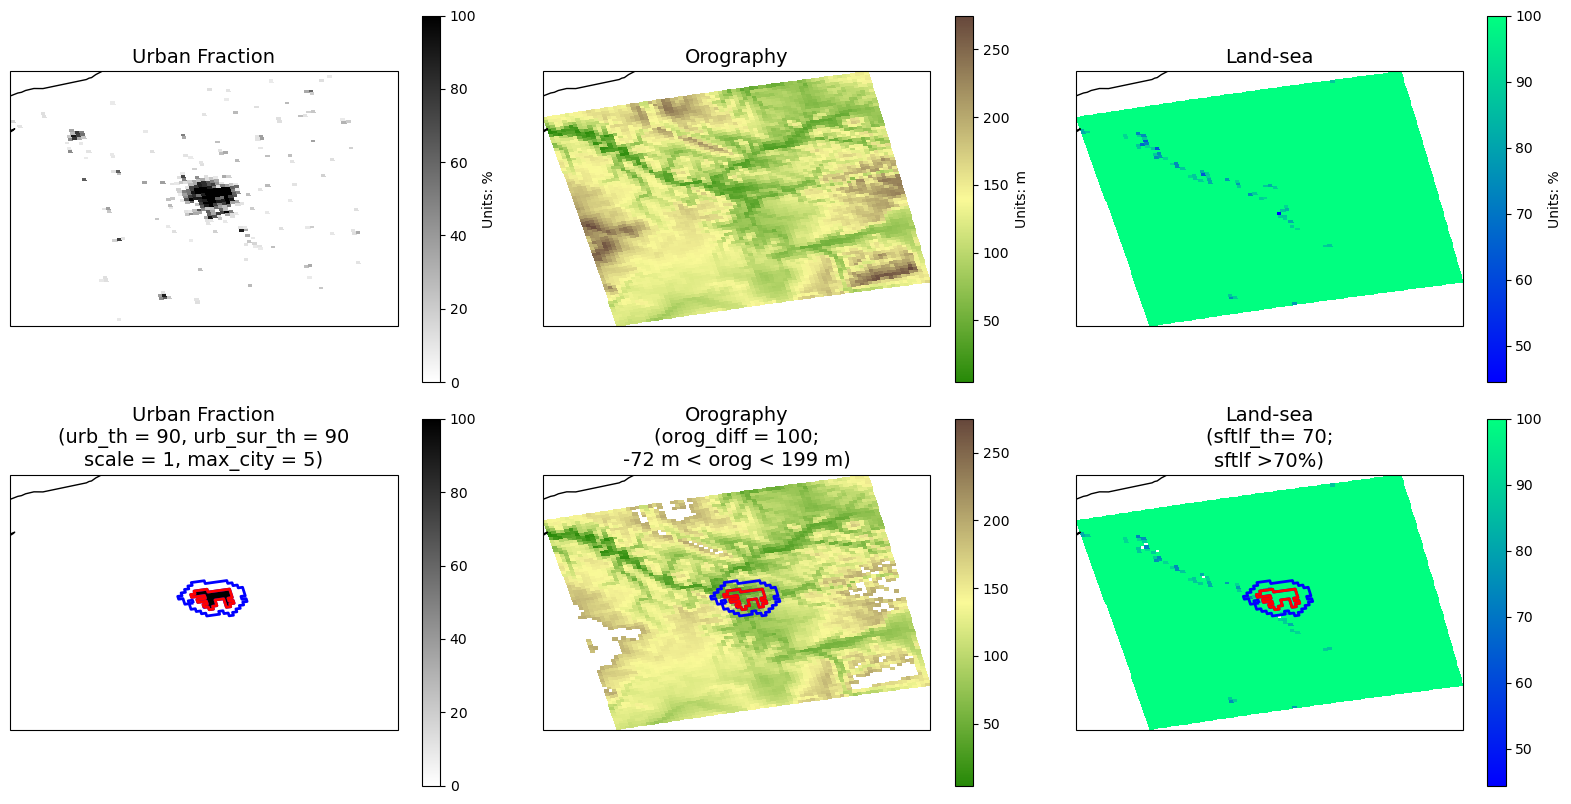

In [115]:
fig = URBAN.plot_static_variables(ds_sfturf = ds_sfturf, 
                                  ds_orog = ds_orog, 
                                  ds_sftlf = ds_sftlf,
                                  sfturf_mask = sfturf_mask, 
                                  orog_mask = orog_mask, 
                                  sftlf_mask = sftlf_mask,
                                  urban_areas = urmask)
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')